# PACKAGES

The following packages were needed to implement RTEA. The "PyGMO" package shown below as "pygmo" is a scientific library providing a large number of optimisation problems and algorithms. We used the package in order to use the following implementations:

- **fast_non_dominated_sorting:** An implementation of the fast non dominated sorting algorithm.
- **select_best_N_mo:** Sorts a population with respect to the following strict ordering:

          i)f1≺f2 if the non domination ranks are such that i1<i2.

          ii) In case i1=i2, then f1≺f2 if the crowding distances are such that  d1>d2.

For more information visit: https://esa.github.io/pagmo2/index.html

In [1]:
import pygmo as pg
from pygmo import hypervolume
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

# SIMULATION MODEL

Simulation Model translated from Matlab to Python

In [2]:
#   ****************************************
#   ***   Code written by Jessica Wu     ***
#   ***        lw353@cornell.edu         ***
#   ****************************************

# Translated by Michael Luya from Matlab to Python on 3/4/2018.
# Updated by Aliya Jangabylova on 3/4/2018.

# Last updated 8/1/2012

# RETURNS: average total cost of production, transportation, outsourcing,
# and inventory holdings

import numpy as np
import randomstate as rnd
import random as rd

def SupplyChain(x, runlength = 2, seed = random.randint(1,10000)):
    
    x = np.reshape(x,(5,3))
# x is a 5x3 matrix, and it specifies the policy used to determine production
# runlength is the number of years to run the simulation
# seed is the index of the substreams to use (integer >= 1)
# other is not used

    if (np.sum(np.sum(k < 0 for k in x))>0 or (runlength <= 0) or
        (runlength != round(runlength)) or (seed <= 0) or (round(seed) != seed)):
        print('x should be >= 0, runlength should be positive integer, seed must be a positive integer\n')
        
    else:
        T = 52 # number of periods
        var = .3 # coeff of the variation of demand
        facilities = 3 # number of production plants
        salesRegions = 8
        products = 5 # number of products
        C = [.3, .5, .4, .2, .4] # production cost in dollars
        t = .02 # transportation cost 
        h = [.4, .3, .6, .2, .3] # inventory cost
        # e = [.8 .7 1.2 .9 1.1] # outsourcing cost
        e = [0.01, 0.01, 0.01, 0.01, 0.01] # outsourcing cost
        distance = np.array([[32, 21, 19, 31, 22, 35, 18, 33],
                            [25, 36, 30, 24, 16, 14, 31, 19],
                            [18, 12, 27, 11, 33, 28, 23, 22]]) # distance in miles from facility to sales region
        maximum = 70 # maximum order size
        minimum = 1 # minimum order size
        
    ## Generate data ##############################################################################################
    
    ExpectedStream = rnd.prng.mrg32k3a.RandomState(seed)
    DemandStream = ExpectedStream # MODIFIED JUAN
    
    U = np.round(ExpectedStream.normal(6,2,size = [5,8])); # mean demand from each region for each product
    U = U.astype(int)
    
    demands = np.zeros((products, salesRegions, T*runlength))
    
    for i in range(0,T*runlength): 
        
        demands[:,:,i] = np.round(DemandStream.normal(U,np.sqrt(var)))
        
        #The while loop runs until the accumulated demand is between minimun and maximun (JUAN)
        while np.sum(np.sum(k < minimum for k in demands[:,:,i])) or np.sum(np.sum(k > maximum for k in demands[:,:,i])):
            
            demands[:,:,i] = np.round(DemandStream.normal(U,np.sqrt(var)))

    ## Main Simulation ############################################################################################
    
    P = np.zeros((products,facilities, T*runlength)) # amount produced
    S = np.zeros((products,facilities, T*runlength)) # amount transported
    O = np.zeros((products,salesRegions, T*runlength)) # amount outsourced
    I = np.zeros((products,facilities, T*runlength+1)) # inventory levels
    serviceLevel = 0
    
    targetInventory = np.zeros((products, facilities))
  
    # COMPUTES THE INVENTORY IN EACH FACILITY TO SUPPLY THE THREE NEAREST SALES REGIONS.
    # IF X=1's the inventory is equal to the demand. COMMENT JUAN
    for i in range(0,facilities):       
        base = 0    
        for j in range(0,3):     
            low = 1000
            index = 0         
            for k in range(0,salesRegions): # finding the three closest sales regions           
                dki = distance[i,k] #COMPUTING DISTANCE BETWEEN FACILITIES AND SALES REGIONS. CHANGED BY JUAN
                if dki < low and dki >base:            
                    low = dki
                    index = k         
            base = low
            targetInventory[:,i] = targetInventory[:,i] + U[:,index] # targetInv at facility i and mean demand at sales region_index
            # total targetInventory from all facilities
#     print('Mean Demand')
#     print(U)
    
    targetInventory = np.multiply(targetInventory, x) #JBR
  
    for i in range(0,T*runlength):
#         print('Inventory lvl:' ,I[:,:,i])
#         print('Demand product x SalesRegion:' ,demands[:,:,i])
#         print('targetInventory: ',targetInventory)
#         print('Amount Produced(P) products x facilities: ',P[:,:,i])
#         print('Amount Transported(S) products x facilities: ',S[:,:,i])
#         print('Amount Outsourced(O) products x salesregions: ',O[:,:,i])
        if (I[:,:,i] < targetInventory).all(): #MODIFIED JUAN. Now produces everytime there's a shortage in any product on inventary
            P[:,:,i] = targetInventory - I[:,:,i] # producing to the target inventory level
            I[:,:,i] = I[:,:,i] + P[:,:,i]  # total amount of target inventory level

        #FINDING CLOSEST FACILITY. SAME STRUCTURE AS BEFORE.COMMENT BY JUAN. 
        for j in range(0,salesRegions):
            base = 0
            for m in range(0,3):   
                low = 1000
                index = 0
                for k in range(0,facilities): # find the closest facilities 
                    dkj = distance[k,j] # CHANGED BY JUAN
                    if dkj < low and dkj > base:  
                        low = dkj
                        index = k
                    
                for k in range(0,products): # facility fills the orders
                    
                    if demands[k,j,i] > I[k,index,i] and demands[k,j,i] > 0:
                        
                        demands[k,j,i] = demands[k,j,i] - I[k,index,i]  # total demand - inv.levels
                        S[k,index,i] = I[k,index,i]  # amount transported = inventory levels
                        I[k,index,i] = 0
                        I[k,index,i+1] = I[k,index,i] #MODIFIED JUAN
                        
                    elif demands[k,j,i] <= I[k,index,i] and demands[k,j,i] > 0:
                        
                        S[k,index,i] = demands[k,j,i] # transport all the demands
                        demands[k,j,i] = 0  # zero demands left
                        I[k,index,i] = I[k,index,i] - S[k,index,i]  # inv.level at facility..- amount transported
                        #if i < T*runlength-1:   # otherwise i+1 is bigger than the size T*runlength #MODIFIED JUAN
                        I[k,index,i+1] = I[k,index,i]
                                        
                    base = low # to find the next closest facility


            for k in range(0,products):
                
                if demands[k,j,i] > 0: # remaining order is filled by outsourcing
                    
                    O[k,j,i] = demands[k,j,i]
                    demands[k,j,i] = 0
                    serviceLevel += 1
                    
            

# Single objective 
    costs = np.sum(C*np.sum(np.sum(P,axis = 2),axis = 1)) + np.sum(t*np.sum(np.sum(S,axis = 2),axis = 1)) + np.sum(e*np.sum(np.sum(O,axis = 2),axis = 1))+ np.sum(h*np.sum(np.sum(I,axis = 2),axis = 1))
                
    
    ## End of Simulation; Generate results ######################################################################
    
    fn =  costs/runlength/np.sum(np.sum(np.sum(P,axis = 2),axis = 1)) # cost function
    fn2 = np.float((products*salesRegions*runlength*T - serviceLevel))/np.float(products*salesRegions*T*runlength) #customer service level

    return [fn, -fn2]

/usr/local/lib/python2.7/dist-packages/randomstate/__init__.py:66: RandomStateDeprecationWarning: 
**End-of-life notification**

This library was designed to bring alternative generators to the NumPy 
infrastructure. It as been successful in advancing the conversation 
for a future implementation of a new random number API in NumPy which 
will allow new algorithms and/or generators. The next step
in this process is to separate the basic (or core RNG) from the 
functions that transform random bits into useful random numbers.
This has been implemented in a successor project  **randomgen** 
available on GitHub

https://github.com/bashtage/randomgen

or PyPi

https://pypi.org/project/randomstate/.

randomgen has a slightly different API, so please see the randomgen documentation

https://bashtage.github.io/randomgen.

  warnings.warn(DEPRECATION_MESSAGE, RandomStateDeprecationWarning)


# ALGORITHM SETTING AND SOLUTION

class **RTEA** is the optimisation algorithm used for Supply Chain. This recives just the initial population size,evaluations to the supply chain code and the parameter k as input.

In [59]:
class RTEA:

    def evolve(self, pop, evaluations=4000, k_iterations=1):

        g = evaluations    #number of evaluations made
        pop_size = pop     #Initial population size
        p_cross = 0.95     # Probability to a apply crossover to a generated individual 
        lb = 0.6           #Lower Bound of each element of the input variable
        ub = 1.1           #Upper Bound of each element of the input variable
        cont_dim = 15      #Dimension of the input variable. This will be resized inside Supply Chain code as a 5x3 matrix   
        search_proportion = 0.95   #Percentage of iterations that pass before turning off main part of the algorithm and just apply the Rolling Tide loop (SEE JUST --SECOND BIG LOOP--)
        t=pop              #Counts the number of evaluations made in the supply chain code.
        
        #%%%%%%%%%%%%%%%%%% Just applicable for stats shown in the report for hypervolume computation
        rf = True
        HyperC_list = []
        ref_point = [ 1.0 , -0.1] # reference point set for hypervolume computation.
        #%%%%%%%%%%%%%%%%%%%
        
        INDV_F ={}        #Dictionary with a numerical tag for each individual and all the Objective function values obtained from re-evaluation.
        POPU_X = {}      #Dictionary with a numerical tag for each individual and the associated decision variable.
        POPU_F = {}      #Dictionary with a numerical tag for each individual and the associated ESTIMATION of Objective function. For each individual, this is the mean of INDV_F
        samples_A = {}   #Number of re-evaluations for each non-dominated individual.
        samples_pop = {} #Number of re-evaluations for all individuals. Dominated and non-dominated.
        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        #INITIALIZING RANDOM POPULATION
        
        for j in range(pop_size):
            POPU_X[j] = [random.uniform(lb,ub) for i in range(cont_dim)]
            POPU_F[j] = list(SupplyChain(list(POPU_X[j]),2,random.randint(1,1000)))
            INDV_F[j] = [POPU_F[j]]
       
        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        # The algorithm now starts manipulating the population
        
        #LEGEND 
        
        #A:Decision variable "x" of Non-Dominated individuals
        #F: Value of Decision variable "SupplyChain(x)" of non-Dominated individuals.
        #X: Decision variable "x" of Dominated individuals.class RTEA:

    def evolve(self, pop, evaluations=4000, k_iterations=1):

        g = evaluations    #number of evaluations made
        pop_size = pop     #Initial population size
        p_cross = 0.95     # Probability to a apply crossover to a generated individual 
        lb = 0.6           #Lower Bound of each element of the input variable
        ub = 1.1           #Upper Bound of each element of the input variable
        cont_dim = 15      #Dimension of the input variable. This will be resized inside Supply Chain code as a 5x3 matrix   
        search_proportion = 0.95   #Percentage of iterations that pass before turning off main part of the algorithm and just apply the Rolling Tide loop (SEE JUST --SECOND BIG LOOP--)
        t=pop              #Counts the number of evaluations made in the supply chain code.
        
        #%%%%%%%%%%%%%%%%%% Just applicable for stats shown in the report for hypervolume computation
        rf = True
        HyperC_list = []
        ref_point = [ 1.0 , -0.1] # reference point set for hypervolume computation.
        #%%%%%%%%%%%%%%%%%%%
        
        INDV_F ={}        #Dictionary with a numerical tag for each individual and all the Objective function values obtained from re-evaluation.
        POPU_X = {}      #Dictionary with a numerical tag for each individual and the associated decision variable.
        POPU_F = {}      #Dictionary with a numerical tag for each individual and the associated ESTIMATION of Objective function. For each individual, this is the mean of INDV_F
        samples_A = {}   #Number of re-evaluations for each non-dominated individual.
        samples_pop = {} #Number of re-evaluations for all individuals. Dominated and non-dominated.
        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        #INITIALIZING RANDOM POPULATION
        
        for j in range(pop_size):
            POPU_X[j] = [random.uniform(lb,ub) for i in range(cont_dim)]
            POPU_F[j] = list(SupplyChain(list(POPU_X[j]),2,random.randint(1,1000)))
            INDV_F[j] = [POPU_F[j]]
       
        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        # The algorithm now starts manipulating the population
        
        #LEGEND 
        
        #A:Decision variable "x" of Non-Dominated individuals
        #F: Value of Decision variable "SupplyChain(x)" of non-Dominated individuals.
        #X: Decision variable "x" of Dominated individuals.
        #Y:Value of Decision variable "SupplyChain(x)" of Dominated individuals.
        
        A,F,X,Y = get_A_F(POPU_X,POPU_F) #Get non-dominated individuals decision vectors and value from initial population 
       
        
        for i in A.keys():    #This loops set the counter to 1 for each individual
            samples_A[i] = 1
            samples_pop[i] = 1
        M = len(POPU_X)-1 #M is just an auxiliary variable inside the code
        
        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        #LVL1. Checks if the condition if the 4000 iterations passed in order to stop the optimisation algorithm.
        while t<=g:
            #print(t,' evaluations made in Supply Chain code')   #Sanity check
            
            #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
            #This part only calculates the Hypervolume computation for each iteration. In case where this is not necessary, it can be set as comment.
            F1 = []
            F2 = []
            
            Obj_val = F.values()
            
            F1 = [ Obj_val[j][0] for j in range(len(Obj_val))]
            F2 = [ Obj_val[j][1] for j in range(len(Obj_val))]
            
            F_HV = [[ F1[i],F2[i]] for i in range(len(F1))]            
            hv = hypervolume(F_HV)
            
            while (rf):
                rf = False
            HVval = hv.compute(ref_point)
            #print('hv',hv.compute(ref_point))
            HyperC_list.append(HVval)
            #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
            
            
            #FIRST LOOP
            #The main objective of this loop is generate new individuals using a simple crossover and mutation.
            #After the new individual is created the sets A,F and X,Y are updated.
            if t< search_proportion*g: #In the case of 4000 total evaluations, the algorithm will spend 3800 evaluations creating new individuals
  
                aux_F = F.values()  #Auxiliary list F
                aux_A = A.values()  #Auxiliary list A
        
                #SELECTION OF PARENTS AND CROSSOVER
                if len(aux_F) > 1:              
                    u_i,v_i = pg.select_best_N_mo(aux_F,2) #USE CROWDING DISTANCE along with ranking to select best two individuals.
                    u , v = aux_A[u_i],aux_A[v_i]

                    #crossover operation, generates 1 offspring
                    if random.uniform(0,1) < p_cross:
                        father, mother = u,v
                        index1 = random.randint(1, len(father) - 2)
                        index2 = random.randint(1, len(father) - 2)
                        if (index1 > index2):
                              index1, index2 = index2, index1
                        child = father[:index1] + mother[index1:index2] + father[index2:]
                        x = child
                    else:
                        x = u
                else:
                    x = A.values()[0]
                    
                #MUTATION, mutates the offspring varying one element of string with a uniform random distribution.
                index = random.randint(0, len(x) - 1)
                vary = random.uniform(lb, ub)
                mutated = list(x)
                mutated[index] = vary
                M+=1
          
                POPU_X[M] = mutated
                POPU_F[M] = list(SupplyChain(mutated,2,random.randint(1,1000)))

                INDV_F[M] = []
                INDV_F[M].append(POPU_F[M])
                
                #UPDATES A,F, X, Y, samples_A, samples_pop with new individual
                A,F,X,Y = get_A_F(POPU_X,POPU_F)
                samples_A,samples_pop = update_A(samples_pop,A)
                t+=1       
                     
            samples_A,samples_pop = update_A(samples_pop,A)
            
            #SECOND LOOP. Re-evaluation or Rolling Tide part of the algorithm.
            #if k_iterations is set to 1, the algorithm will re-evaluate just once for each iteration.
            for k in range(k_iterations):
                #print(t,' evaluations made in Supply Chain code')   #Sanity check
                #finding element of A with smallest sample size
                x_pp = min(samples_A, key=samples_A.get)

                #evaluation of function
                DX = A[x_pp]
                y_pp = list(SupplyChain(list(DX),2,random.randint(1,1000)))
                
                #updating mean est(F)
                samples_A[x_pp] +=1
                samples_pop[x_pp] +=1   
                INDV_F[x_pp].append(y_pp)               
                F0 = np.mean(np.matrix(INDV_F[x_pp])[:,0]) 
                F1 = np.mean(np.matrix(INDV_F[x_pp])[:,1])
                F_est = [F0,F1]
                POPU_F[x_pp] = F_est

                #+1 to the budget
                t+=1

                #Update A, F, X, Y
                A,F,X,Y = get_A_F(POPU_X,POPU_F)
                samples_A,samples_pop = update_A(samples_pop,A)
        print('FINISHED.')
        return A,F,t,INDV_F,samples_A, HyperC_list,ref_point
        #Y:Value of Decision variable "SupplyChain(x)" of Dominated individuals.
        
        A,F,X,Y = get_A_F(POPU_X,POPU_F) #Get non-dominated individuals decision vectors and value from initial population 
       
        
        for i in A.keys():    #This loops set the counter to 1 for each individual
            samples_A[i] = 1
            samples_pop[i] = 1
        M = len(POPU_X)-1 #M is just an auxiliary variable inside the code
        
        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        #LVL1. Checks if the condition if the 4000 iterations passed in order to stop the optimisation algorithm.
        while t<=g:
            #print(t,' evaluations made in Supply Chain code')   #Sanity check
            
            #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
            #This part only calculates the Hypervolume computation for each iteration. In case where this is not necessary, it can be set as comment.
            F1 = []
            F2 = []
            
            Obj_val = F.values()
            
            F1 = [ Obj_val[j][0] for j in range(len(Obj_val))]
            F2 = [ Obj_val[j][1] for j in range(len(Obj_val))]
            
            F_HV = [[ F1[i],F2[i]] for i in range(len(F1))]            
            hv = hypervolume(F_HV)
            
            while (rf):
                rf = False
            HVval = hv.compute(ref_point)
            #print('hv',hv.compute(ref_point))
            HyperC_list.append(HVval)
            #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
            
            
            #FIRST LOOP
            #The main objective of this loop is generate new individuals using a simple crossover and mutation.
            #After the new individual is created the sets A,F and X,Y are updated.
            if t< search_proportion*g: #In the case of 4000 total evaluations, the algorithm will spend 3800 evaluations creating new individuals
  
                aux_F = F.values()  #Auxiliary list F
                aux_A = A.values()  #Auxiliary list A
        
                #SELECTION OF PARENTS AND CROSSOVER
                if len(aux_F) > 1:              
                    u_i,v_i = pg.select_best_N_mo(aux_F,2) #USE CROWDING DISTANCE along with ranking to select best two individuals.
                    u , v = aux_A[u_i],aux_A[v_i]

                    #crossover operation, generates 1 offspring
                    if random.uniform(0,1) < p_cross:
                        father, mother = u,v
                        index1 = random.randint(1, len(father) - 2)
                        index2 = random.randint(1, len(father) - 2)
                        if (index1 > index2):
                              index1, index2 = index2, index1
                        child = father[:index1] + mother[index1:index2] + father[index2:]
                        x = child
                    else:
                        x = u
                else:
                    x = A.values()[0]
                    
                #MUTATION, mutates the offspring varying one element of string with a uniform random distribution.
                index = random.randint(0, len(x) - 1)
                vary = random.uniform(lb, ub)
                mutated = list(x)
                mutated[index] = vary
                M+=1
          
                POPU_X[M] = mutated
                POPU_F[M] = list(SupplyChain(mutated,2,random.randint(1,1000)))

                INDV_F[M] = []
                INDV_F[M].append(POPU_F[M])
                
                #UPDATES A,F, X, Y, samples_A, samples_pop with new individual
                A,F,X,Y = get_A_F(POPU_X,POPU_F)
                samples_A,samples_pop = update_A(samples_pop,A)
                t+=1       
                     
            samples_A,samples_pop = update_A(samples_pop,A)
            
            #SECOND LOOP. Re-evaluation or Rolling Tide part of the algorithm.
            #if k_iterations is set to 1, the algorithm will re-evaluate just once for each iteration.
            for k in range(k_iterations):
                #print(t,' evaluations made in Supply Chain code')   #Sanity check
                #finding element of A with smallest sample size
                x_pp = min(samples_A, key=samples_A.get)

                #evaluation of function
                DX = A[x_pp]
                y_pp = list(SupplyChain(list(DX),2,random.randint(1,1000)))
                
                #updating mean est(F)
                samples_A[x_pp] +=1
                samples_pop[x_pp] +=1   
                INDV_F[x_pp].append(y_pp)               
                F0 = np.mean(np.matrix(INDV_F[x_pp])[:,0]) 
                F1 = np.mean(np.matrix(INDV_F[x_pp])[:,1])
                F_est = [F0,F1]
                POPU_F[x_pp] = F_est

                #+1 to the budget
                t+=1

                #Update A, F, X, Y
                A,F,X,Y = get_A_F(POPU_X,POPU_F)
                samples_A,samples_pop = update_A(samples_pop,A)
        print('FINISHED.')
        return A,F,t,INDV_F,samples_A, HyperC_list,ref_point


In [60]:
#get_A_F updates the sets A, F, X, Y 
def get_A_F(pop_X,pop_F):
    
    index_pareto_front =pg.fast_non_dominated_sorting(pop_F.values())[0][0]
    X = {}
    Y = {}
    A = {}
    F = {}
    #ELEMENTS PARETO FRONT
    for i in list(index_pareto_front):
        A[int(i)] = pop_X[int(i)]
        F[int(i)] = pop_F[int(i)]
    
    #ELEMENTS NON PARETO FRONT
    a = np.array([])
    for i in list(pg.fast_non_dominated_sorting(pop_F.values())[0][1:-1]):
        
        a = np.concatenate((a,i))
    for i in list(a):
        X[int(i)] = pop_X[int(i)]
        Y[int(i)] = pop_F[int(i)]

    return A,F,X,Y

#update_A updates the samples_A and samples_pop 
def update_A(sample_pop,A_new):

    list_dif = A_new.keys()
    S = {}
    for i in list_dif:
        if i in sample_pop:
            S[i] = sample_pop[i]
        else:
            S[i] = 1
            sample_pop[i] = 1
    return S,sample_pop     

# APLICATION OF THE ALGORITHM

In [61]:
#INPUT
#evl is the number of evaluations in the supply chain code
#pop_size is the initial random population size
#k is the number of re-evaluations for each iteration of the algorithm

#OUTPUT
#A: decision vector for non-dominated individuals.
#F: estimated value of the decision vector for non-dominated individuals.
#t number of evaluations made inside the algorithm
#samples_A: number of evaluations for each instance.
#INDV_F: value of each evaluation made for each instance.
#HV_curve: hypervolume metric taken inside the algorithm.
#ref_point: reference point taken for the hypervolume metric

evl =4000
pop_size =40
k=1

alg = RTEA()
A,F,t,INDV_F,samples_A, HV_curve,ref_point  = alg.evolve(pop_size,evaluations=evl,k_iterations=k)

FINISHED.


# OUTPUT EXPLAMPLE EXPLANATION

In [64]:
#EXAMPLE TO UNDERSTAND OUTPUT.
#Let's choose first individual of A set.
print('tag of the first individual inside the A set')
print(A.keys()[0])
print('')
print('15 dimensional decision variable for that individual')
print(A[A.keys()[0]])
print('')
print('How many evaluations were taken for that individual (samples_A)')
print(samples_A[A.keys()[0]])
print('')
print('Estimated value of the decision variable (F)')
print(F[A.keys()[0]])

tag of the first individual inside the A set
129

15 dimensional decision variable for that individual
[0.9115410142159259, 0.833241516766259, 0.8508523928768054, 1.0040769101270808, 0.6471689227922279, 0.8593246052375305, 0.9542701521693413, 0.7365837425877396, 0.9496584361081337, 1.0405759165968693, 1.0498266875199547, 0.8532772022595396, 0.8799873323846781, 0.8551076689000845, 0.9975151385863862]

How many evaluations were taken for that individual (samples_A)
18

Estimated value of the decision variable (F)
[0.185355204585391, -0.943162393162393]


# OUTPUT PLOT

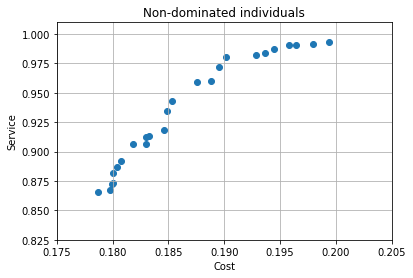

In [66]:
#RESULTING non-dominated front PLOT from 1 realization of the algorithm
#In order to compare the data with ESTECO's benchmark multiply by -1 the second objective function.

plt.scatter(np.array(np.matrix(F.values())[:,0]),-np.array(np.matrix(F.values())[:,1]))
plt.title('Non-dominated individuals')
plt.ylim((0.825,1.01))
plt.xlim((0.175,0.205))
plt.xlabel('Cost')
plt.ylabel('Service')
plt.grid()
plt.show()